<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Общая-информация" data-toc-modified-id="Общая-информация-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Общая информация</a></span></li><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Разность-временного-ряда" data-toc-modified-id="Разность-временного-ряда-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Разность временного ряда</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Подготовка

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sweetviz as sw
import warnings
from IPython.display import display, HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

In [4]:
warnings.filterwarnings('ignore')

In [5]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('taxi.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [8]:
data['datetime'] = data['datetime'].astype('datetime64')

In [9]:
data['datetime'].is_monotonic

True

In [10]:
data_resample = data.set_index('datetime').resample('1H').sum()

In [11]:
data_resample.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Вывод по 1 шагу: В 1 части проекта были подключены необходимые инстременты для работы. Загружен датасет. Вывели общую информацию о нем и первые 5 строк для ознакомления с данными. В данных был обнаружен столбец с датой, поменял его тип на datetime64. Проверил последовательны ли расположены даты в столбце, соответствуюшая функция показала, что данные расположены в хронологическом порядке. Ресемплировал датасет по часам, агрегировав суммой.**

## Анализ

### Общая информация

In [12]:
report = sw.analyze([data, "Taxi"])
report.show_html('common_analysis_taxi.html')

                                             |          | [  0%]   00:00 -> (? left)

Report common_analysis_taxi.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [13]:
display(HTML('''<script type="text/javascript">
                   window.open("common_analysis_taxi.html", "_blank");
               </script>'''))

**Маленький датасет можно изучить с помощью готовых инструментов из библиотеки sweetviz. Выведенные отчет показал отсутствие пропусков и дубликатов, что очень важно для дальнейшего исследования. Другие интересующие параметры можно найти в отчете.**

### Скользящее среднее

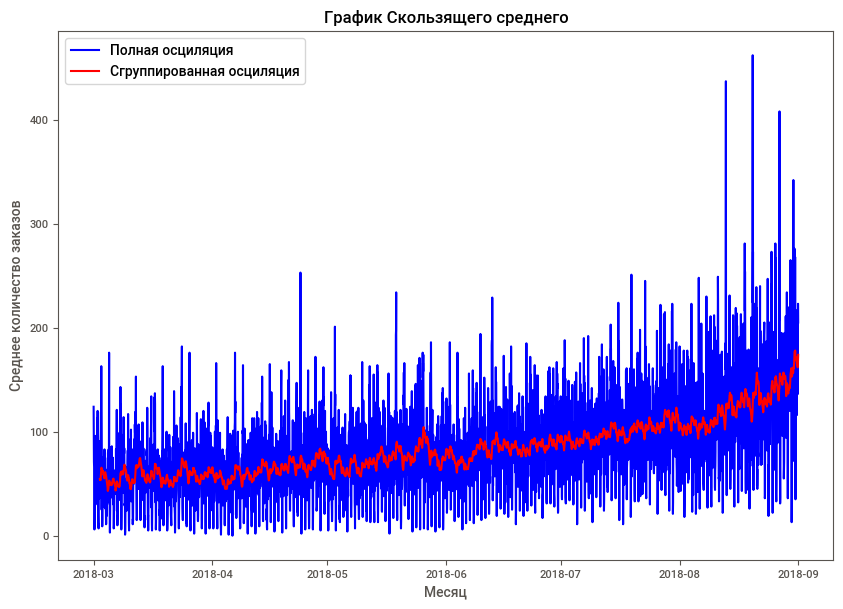

In [14]:
plt.figure(figsize=(10,7))
plt.plot(data_resample, color='b', label='Полная осциляция')
plt.plot(data_resample.rolling(40).mean(), color='r', label='Сгруппированная осциляция')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество заказов')
plt.title('График Скользящего среднего')
plt.legend()
plt.show()

**Видим, что какие либо наблюдения сложно делать по полному графику распределения количества заказов по часам, поэтому пришлось данные немного скорректировать, красным показано как колеблется среднее количетсво заказов по часам каждые 40 наблюдений. Заметно, что с марта до сентябрь рассматриваемое среднее плавно растет, но колебания продолжаются все равно. Особенно выделяются участки в конце мая и в конце августа, где виден резкий скачек величины**

### Тренды и сезонность

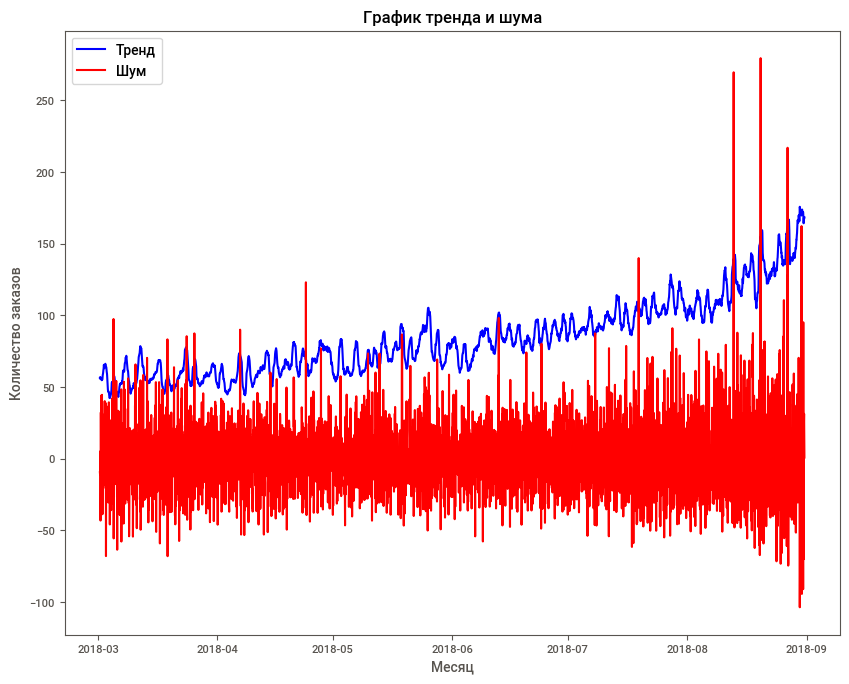

In [15]:
plt.figure(figsize=(10,8))
plt.plot(seasonal_decompose(data_resample).trend, color='b', label='Тренд')
plt.plot(seasonal_decompose(data_resample).resid, color='r', label='Шум')

plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('График тренда и шума')
plt.legend()
plt.show()

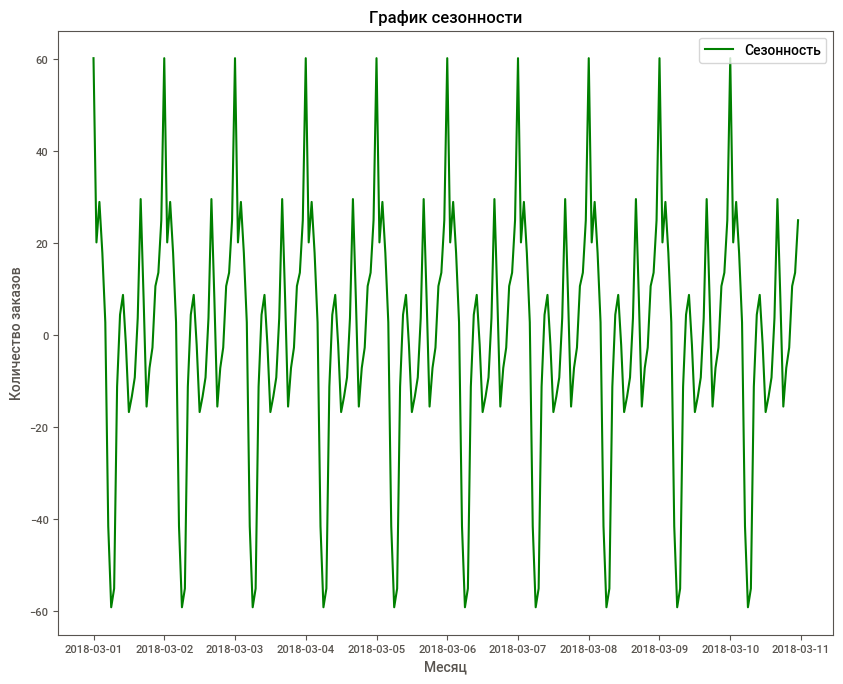

In [16]:
plt.figure(figsize=(10,8))
plt.plot(seasonal_decompose(data_resample).seasonal['2018-03-01':'2018-03-10'], color='g', label='Сезонность')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('График сезонности')
plt.legend()
plt.show()

**Теперь рассмотрим графики тренда, сезонности и шума в данных.**

**Тренд:**

- На графике видно, что тренд показывает устойчивый рост количества заказов такси с течением времени. Это может свидетельствовать о росте популярности сервиса такси или увеличении общей активности в определённый период.
Рост тренда сопровождается колебаниями, но основное направление линии — восходящее.

**Cезонность:**

- Сезонность выражена довольно стабильно и повторяется с регулярными интервалами. Это означает, что в определённые периоды времени наблюдаются цикличные колебания в количестве заказов.
Сезонные колебания могут отражать особенности спроса на такси в зависимости от времени суток, дня недели или месяца. Например, это может быть связано с определёнными пиковыми часами (утром, вечером) или днями с высокой активностью.

**Шум:**

- Красная линия представляет собой шум, т.е. остаточную составляющую, которая не объясняется трендом и сезонностью. Здесь шум сильно варьируется, включая резкие пики, особенно в последние периоды временного ряда.
Высокий уровень шума указывает на наличие значительных случайных колебаний в количестве заказов такси, что может быть вызвано непредсказуемыми факторами (например, погодные условия, массовые мероприятия, аварии на дорогах).

### Разность временного ряда

In [17]:
data_shift = data_resample - data_resample.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(40).mean()
data_shift['std'] = data_shift['num_orders'].rolling(40).std()

In [18]:
data_shift

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,NaN
2018-03-01 03:00:00,-5.0,NaN,NaN
2018-03-01 04:00:00,-23.0,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,-71.0,-1.425,80.653703
2018-08-31 20:00:00,18.0,-0.800,80.706242
2018-08-31 21:00:00,5.0,2.575,77.940111


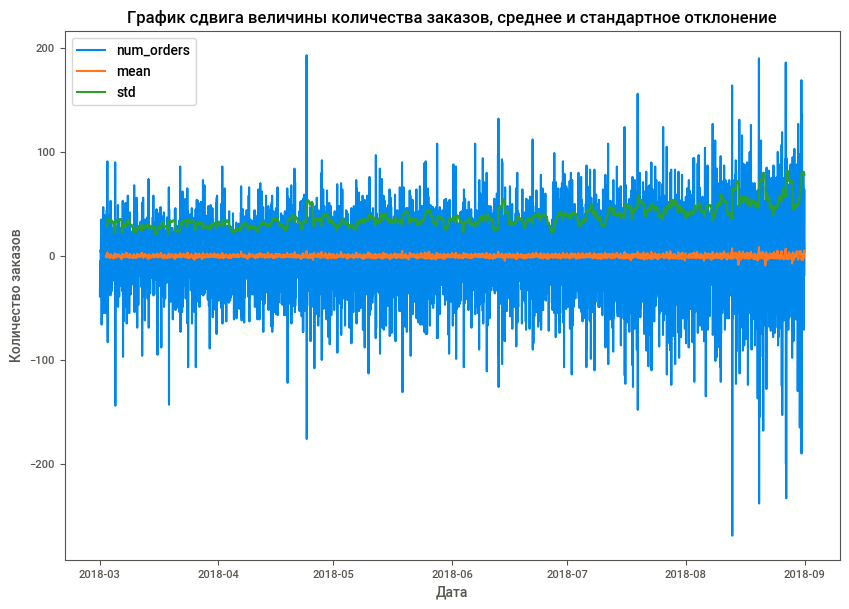

In [19]:
plt.figure(figsize=(10,7))
plt.plot(data_shift)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('График сдвига величины количества заказов, среднее и стандартное отклонение')
plt.legend(['num_orders', 'mean', 'std'])
plt.show()

Сдвиг величины количества заказов (синяя линия)

На графике представлены три компонента: сдвиг количества заказов такси (`num_orders`), среднее значение (`mean`) и стандартное отклонение (`std`), вычисленные с помощью скользящего окна.

1. **Сдвиг величины количества заказов (синяя линия)**:
   - Сдвиг представляет собой разность между текущим значением и предыдущим, что показывает изменения в заказах такси от одного момента к другому.
   - Можно заметить значительные колебания вверх и вниз, включая как положительные, так и отрицательные пики.
   - Это указывает на высокую изменчивость данных, где на одни часы может приходиться резкий рост заказов, а на другие — резкое снижение.

2. **Среднее значение (оранжевая линия)**:
   - Оранжевая линия показывает сглаженную динамику изменений, усреднённую по скользящему окну длиной в 40 периодов.
   - Среднее значение остаётся относительно стабильным, что говорит о том, что в долгосрочной перспективе изменения в количестве заказов имеют сбалансированный характер, хотя краткосрочные колебания могут быть значительными.

3. **Стандартное отклонение (зелёная линия)**:
   - Зелёная линия отражает изменчивость данных в пределах каждого скользящего окна. Чем выше стандартное отклонение, тем больше вариаций в количестве заказов в данный момент времени.
   - Видно, что стандартное отклонение периодически увеличивается, что соответствует моментам больших изменений (всплесков) в количестве заказов.
   - Это может указывать на периоды повышенной нестабильности спроса на такси, когда различия в заказах в пределах одного дня становятся более выраженными.

### Создание признаков

In [20]:
def make_features(data, column, lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, lag + 1):
        data_new['lag_' + str(lag)] = data_new[column].shift(lag)

    data_new['rolling_mean'] = data_new[column].shift().rolling(rolling_mean_size).sum()
    
    return data_new
    

In [21]:
data_new = make_features(data_resample, 'num_orders', 25, 6)

**make_features - функция, которая создает в датасете дополнительные признаки для обучения модели. Данные представлены за 2018 год, поэтому год можно не добавлять. появяться месяц, день и день недели, а также 25 столбцов со смещенными данными и 1 с суммарным количеством заказов при сдвиге с окном 6.**

## Обучение

In [22]:
num_columns = data_new.drop(['num_orders', 'month', 'day', 'dayofweek'], axis=1).columns
ohe_columns = ['month', 'day', 'dayofweek']

**Разделение признаков на две части под 2 типа кодирования.**

In [23]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train = train.dropna()

In [24]:
X_train, y_train, X_test, y_test = (train.drop('num_orders', axis=1), train['num_orders'].reset_index()['num_orders'], 
                                    test.drop('num_orders', axis=1), test['num_orders'].reset_index()['num_orders'])

In [25]:
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_columns),
        ],
    remainder = 'passthrough')

### Линейная регрессия

In [26]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

In [27]:
param_grid = {
    'preprocessor__num': ['passthrough', StandardScaler(), MinMaxScaler()]
}

In [28]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=TimeSeriesSplit(5),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
            )

In [29]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22',
       'lag_23', 'lag_24', 'lag_25', 'rolling_mean'],
      dtype='object'))])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'preprocessor__num': ['passthrough', StandardScaler(),
                                               MinMaxScaler()]},
             scoring='neg_root_mean_squared_error')

In [30]:
grid_search.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22',
       'lag_23', 'lag_24', 'lag_25', 'rolling_mean'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [31]:
print('RMSE на кросс-валидации', -grid_search.best_score_)

RMSE на кросс-валидации 27.009624800356413


In [32]:
y_pred_train = grid_search.best_estimator_.predict(X_train)
print('RMSE на тренировочной выборке: ', mean_squared_error(y_train, y_pred_train, squared=False))

RMSE на тренировочной выборке:  25.7759432278792


### Дерево решений

In [33]:
pipe_final_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [34]:
param_grid_tree = {
    'model__max_depth': range(2, 10),
    'model__max_features': range(2, 10),
    'model__min_samples_split': range(2, 10)
}

In [35]:
grid_search_tree = GridSearchCV(
    pipe_final_tree,
    param_grid_tree,
    cv=TimeSeriesSplit(5),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
            )

In [36]:
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22',
       'lag_23', 'lag_24', 'lag_25', 'rolling_mean'],
      dtype='object'))])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': range(2, 10),
                         'model__max_features': range(2, 10),
                         'model__min_samples_split': range(2, 10)},
             scoring='neg_root_mean_squared_error')

In [37]:
grid_search_tree.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22',
       'lag_23', 'lag_24', 'lag_25', 'rolling_mean'],
      dtype='object'))])),
                ('model',
                 DecisionTreeRegressor(max_depth=6, max_features=8,
                                       min_samples_split=8, random_state=42))])

In [38]:
print('RMSE на кросс-валидации', -grid_search_tree.best_score_)

RMSE на кросс-валидации 29.565010738673454


In [39]:
y_pred_train = grid_search_tree.best_estimator_.predict(X_train)
print('RMSE на тренировочной выборке: ', mean_squared_error(y_train, y_pred_train, squared=False))

RMSE на тренировочной выборке:  25.66862046405886


**В данной части проекта была обучена модель линейной регрессии для прогнозирования количества заказов в час. Произведено распределение признаков по типу кодирования. Данные резъединены на тестовую и тренировочную выборку, а также выделен таргет. Тестовая выборка составляет 10% от всего датасета. Модель была найдена на кросс-валидации с параметрами кодирования количественных признаков. В GridSearch применён специальный инструмент TimeSeriesSplit для корректного разъединения данных при поиске гиперпараметров.**

## Тестирование

In [40]:
y_pred_test = grid_search.best_estimator_.predict(X_test)
print('RMSE на тренировочной выборке: ', mean_squared_error(y_test, y_pred_test, squared=False))

RMSE на тренировочной выборке:  45.671435011292914


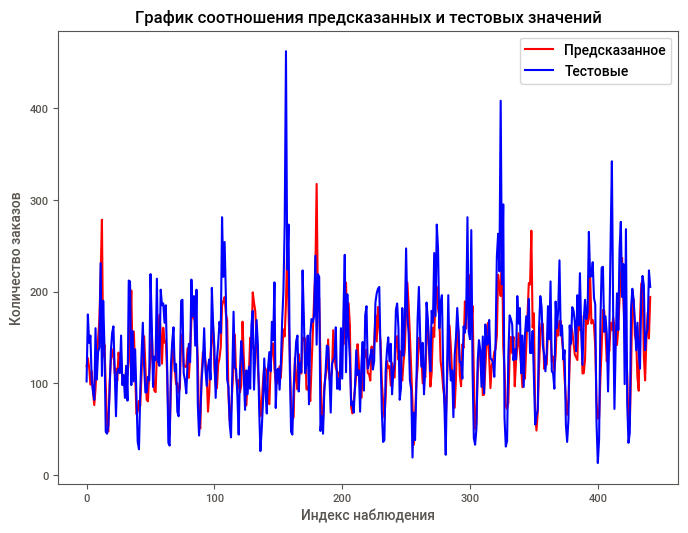

In [41]:
plt.figure(figsize=(8,6))
plt.plot(y_pred_test, color='r', label='Предсказанное')
plt.plot(y_test, color='b', label='Тестовые')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Количество заказов')
plt.title('График соотношения предсказанных и тестовых значений')
plt.legend()
plt.show()

**Тестирование обученой модели**